# IN5400, 2020 | Lab on object detection

## Introduction
This exercise is about making an *image classifier and object localization tool*, much like that described in the first part of the lecture slides.  That is, we will build and train a CNN which produces both an image class label and, if there is a suited class found, a set of regression coefficients providing a bounding box.

In total we have 16451 images, of which 11788 contains a single bird.  None of the other images contains a bird.  The ones with a bird has in addition a bounding box specified.

Our model will *detect if there is a bird* in the image, and if so, *produce a bounding box* surrounding the bird.

Below we have provided a (quite rich) skeleton for you to use as a starting point.  What we want you to do is to **1)** modify a pre-trained VGG16 network/model to allow both image classificaton and bounding-box regression, **2)** implement the two-step loss function (both image classification and regression loss), **3)** calculate the average IoU as well as precision and recall as we progress the training.

The first two tasks need to be done for the code to be able to at all train/fine-tune the model.

Where we suggest you edit the code is marked with "**TASK!**"

Do not expect to see optimized code or clever programming.  Key here is simplicity, in that we hope you find the code easy to understand.

Note that, depending on your setup, it might be an idea to copy the dataset to a local disk.  The dataset is about 1.5 GB.

## Load dataset and show example images

In [13]:
%matplotlib inline

import pickle
import time
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torchvision import models
from tqdm import tqdm

from additionals import *

# Specify data and output folders
pth_data = '/home/christer/IN5400/week9/in5400_2020_lab_detection_data'
pth_work = '/home/christer/IN5400/week9/data_temp' #  [optional] '/path-to-somewhere-you-can-store-intermediate-results/'

# Split the data into a training and validation set, and create data-loaders for each [reduce batch_size if memory issues]
random.seed(42)  # Create "deterministic" train/val split
train_id, val_id = split_cub_set(0.2, pth_data)
datasets = {'train': CUBTypeDataset(train_id, pth_data), 'val': CUBTypeDataset(val_id, pth_data)}
dataloaders = {split: torch.utils.data.DataLoader(datasets[split], batch_size=16, shuffle=(split == 'train'), pin_memory=True) for split in ('train', 'val')}

threshold_IoU = 0.75  # For use in calculating precision and recall

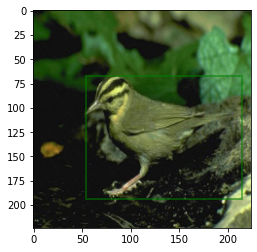

In [16]:
# Visualize an example image from the training data [rerun cell to see more examples]
ind = random.choice(range(len(datasets['train'])))
im, box, im_size = datasets['train'][ind]

im = np.transpose(im.detach().numpy(), [1, 2, 0])

imshow(im, box)

## Construct a model based on a pretrained VGG16 network
As the "backgone", or starting-point model, we have chosen the rather "simple" VGG16 network.  In this model, the *forward* function (which is the one called with the images as input) does the following:

```python
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x
```

The "avgpool(x)" call will produce a 7x7x512 matrix no matter the input size of the images.  (This fits well with the network illustrated in the lecture notes.)  The "self.classifier(x)" step takes as input the 7x7x512 already-flattened cube (made into one long vector) as input and produces a 1000-long output (one for each of the 1000 classes) which is the final output of the model.

What we need to do is to instead let the model output 6 numbers: [c0,c1,x0,y0,x1,y1]. c0 is the probability of background, c1 the probability of bird, while (x0, y0) and (x1, y1) are the upper left and bottom right corner of the bounding box.

The bounding box is relative to the size of the image, just like in the lecture slide examples.  The bounding box, though, is defined using upper-left and lower-right corners instead of its center and height/width as seen in the lecture slides.

A suggestion for solving this first task is that we replace the "classifier" function with a simple linear function transforming the 7x7x512 values into a 6-numbered output.

Replacing the "classifier" function can be done by writing: model.classifier = ...   And a linear transform function can be created using nn.Linear(..).


In [ ]:
# Construct the model based on a pretrained VGG16 "backbone".
model = models.vgg16(pretrained=True)

# Here you need to modify the model.classifier so that it outputs six numbers: [c0 c1 x0 y0 x1 y1]
# TASK! <Do this task first>
model.classifier = 

model = model.cuda()  # Put the model on GPU


In [ ]:
# Verify that your model produces the correct output shape
out = model(torch.rand((1, 3, 224, 224)).cuda())  # Run a single dummy image through the model
assert out.shape == (1, 6), "The output of the model for a single image should be an array of 6 numbers."


In [ ]:
# Specify the functions needed for our final loss criterion
criterion_bbox = nn.MSELoss().cuda()
criterion_cls = nn.CrossEntropyLoss().cuda()

# Specify the optimizer and the learning-rate scheduler -- please feel free to play around with these!
optimizer = optim.SGD(model.parameters(), lr=1e-3, weight_decay=1e-3)
scheduler = optim.lr_scheduler.CyclicLR(optimizer, base_lr=0, max_lr=5e-3, step_size_up=411*2*2, step_size_down=411*12*2, base_momentum=0.9, max_momentum=0.9)  # Increase lr from 0 to 5e-3 linearly during the first two epochs, then let the lr gradually fall back to zero during the next 12 epochs


## Training the model

Here, the first task you should solve (to at all make the program run), is to define and calculate the loss function.

Note that where we suggest you edit the code is marked with "TASK!"

In [ ]:
total_epochs = 14  # Specify for how many epochs we are prepared to train the model

epoch_loss = {'train': [], 'val': []}
epoch_metrics_and_more = {'train': [], 'val': []}

# Train the model by looping through all the images 'total_epochs' times
for epoch in range(total_epochs):
    total_loss = 0
    total_images = 0
    for phase in ('train', 'val'):
        is_training = phase == 'train'
        model.train(is_training)

        start_time = time.time()

        for ims, boxes, im_sizes in tqdm(dataloaders[phase]):

            ims = ims.cuda()
            ids_has_box = np.bitwise_not(np.all(boxes.numpy() == -1, axis=1))
            targets_cls = torch.tensor(ids_has_box, dtype=torch.long).cuda()

            # Run images through the model, producing a set of [c0, c1, x0, y0, y1, y2] for each
            outputs = model(ims)

            # Find average IoU, and store values needed for calculating precision, recall etc.
            # TASK! <We suggest you complete the "loss" task before doing this one>

            # Calculate the loss function
            # TASK! <Do this task first!>
            # loss_cls = # Compute the image classification loss | Hint: Use "criterion_cls(..)" on all [c0 c1] outputs
            # loss_bbox = # Compute the bbox loss | Hint: Use "criterion_bbox(..)" on the [x0 y0 y1 y2] outputs where the ground truth says that we have a bbox (cf. "ids_has_box"/"targets_cls")
            # if not any(ids_has_box):
            #     loss_bbox = torch.zeros(1).cuda()
            # loss = # Compute the total loss | Hint: Combine the cls and bbox loss

            # Add the loss to the total loss this epoch
            total_loss += loss.item()
            total_images += ims.size(0)

            if is_training:
                # Update the weights by doing back-propagation
                # [Note that by doing this last, the CPU can work on loading images for the next iteration while the GPU handles this task]
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                scheduler.step()

        # Calculate precision and recall
        # TASK! <We suggest you complete the "loss" task before doing this one>

        # Print summary for this epoch
        # TASK! <Update this to print more statistics as you add them>
        elapsed_time = time.time() - start_time
        print('[{}]\tEpoch: {}/{}\tAvg loss*10: {:.5f}\tTime: {:.3f} | lr={:.6f}'.format(
            phase, epoch + 1, total_epochs, 10 * total_loss / total_images, elapsed_time, get_lr(optimizer)))
        epoch_loss[phase].append([total_loss / total_images])
        epoch_metrics_and_more[phase].append([get_lr(optimizer)])

    # Save model to file each epoch if so is opted for
    if pth_work is not None:
        torch.save(model, os.path.join(pth_work, 'latest.pth'))


## Now let us visualize some results


In [ ]:
# Plot losses and other metrics
plt.figure(figsize=(10, 8))
for phase in ('train', 'val'):
    plt.plot(range(len(epoch_loss[phase])), np.asarray(epoch_loss[phase])[:, 0]*10, label=(phase + '_loss*10'))
    plt.plot(range(len(epoch_metrics_and_more[phase])), np.asarray(epoch_metrics_and_more[phase])[:, 0], label=(phase + '_lr'))
    # If you store more, add lines for plotting them here, or make new figures for them..
plt.legend(prop={'size': 12})
plt.grid(True)


In [ ]:
# Visualize some prediction results [rerun cell to see more examples]
ind = random.choice(range(len(datasets['val'])))
im, box_gt, im_size = datasets['val'][ind]

outputs = model(im.unsqueeze(0).cuda()).detach()
pred_box = outputs[0, 2:].cpu().numpy()
pred_cls = torch.nn.functional.softmax(outputs[0, 0:2], dim=0)
box_gt = box_gt.numpy()

im = im.detach().numpy()
im = np.transpose(im, [1, 2, 0])

if pred_cls[1] > pred_cls[0]:
    imshow(im, box_gt, pred_box)
    print('Predicted bbox    : {}'.format(pred_box))
    print('Ground-truth bbox : {}'.format(box_gt))
else:
    imshow(im, box_gt)


## Additional questions

- Let us say you now encounter images containing multiple birds.  However, luckily you have at your disposal a tool for providing (somewhat sensible) proposals of sub-regions (parts of the image) that might contain the birds.  How could you ("easily") apply your already-developed image classification and object localization code to handle this multi-bird setting?
- If you did not cover it already when answering that last question, explain what non-max-suppression is and why it is likely that you would need to apply it here?
- In the context of object detection, where we can have multiple objects in a given image, what are anchor boxes (also known as priors or default boxes)?
- Take a look at the figure in the lecture slides illustrating the concepts of the U-net used for image segmentation.  Explain the basic building blocks and concepts behind the algorithm.